In [138]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
import logging
from __future__ import print_function
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential


from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils
from keras.callbacks import History


import matplotlib.pyplot as plt

import matplotlib.cm as cm

import os
import numpy as np
import pdb
import argparse
import logging
import h5py




from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras import initializers
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input
from keras import optimizers
from keras import regularizers
from keras import initializers
from keras import backend as K


In [139]:
IMG_DIM = 48
DATA_DIR = 'data'
DEFAULT_LR = 1e-4
DEFAULT_REG = 0
DEFAULT_NB_EPOCH = 10
DEFAULT_LAYER_SIZE_1 = 64
DEFAULT_LAYER_SIZE_2 = 128
DEFAULT_DROPOUT1 = 0.5
DEFAULT_DROPOUT2 = 0.75
DEFAULT_OUT_DIR = '../outputs/'
DEFAULT_DEPTH1 = 2
DEFAULT_DEPTH2 = 3
DEFAULT_FRAC_POOLING = False
DEFAULT_SAVE_WEIGHTS = True
DEFAULT_USE_BATCHNORM = True
DEFAULT_LOAD_WEIGHTS = False
DEFAULT_PREDICTIONS = False
ITERATION = 3003
num_train = 128 #28709
num_val = 128 #3589
train_data_file = 'train_csv2.csv'
val_data_file = 'valid_csv.csv'
# val_data_file_default = 'test_csv.csv'

EMOTIONS = [
  'Angry',
  'Disgust',
  'Fear',
  'Happy',
  'Sad',
  'Surprise',
  'Neutral',
]

num_classes = 7
nb_classes = 7
batch_size = 128

In [140]:
#load vgg16 without dense layer and with theano dim ordering
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(48,48,3))
#number of classes in your dataset e.g. 20

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
# x = BatchNormalization()(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

#create graph of your new model
head_model = Model(input = base_model.input, output = predictions)
head_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [142]:
def prepare_data(train, val):
    '''
    Return formatted input data.
    '''
    X_train = train[0]
    X_val = val[0]
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_val /= 255

    # Convert from 1-channel images to 3-channel images by duplicating across
    # color channels
    X_train_expanded = np.zeros((X_train.shape[0], 3, X_train.shape[2], X_train.shape[3]))
    X_train_expanded[:, 0, :, :] = X_train[:, 0, :, :]
    X_train_expanded[:, 1, :, :] = X_train[:, 0, :, :]
    X_train_expanded[:, 2, :, :] = X_train[:, 0, :, :]

    X_val_expanded = np.zeros((X_val.shape[0], 3, X_val.shape[2], X_val.shape[3]))
    X_val_expanded[:, 0, :, :] = X_val[:, 0, :, :]
    X_val_expanded[:, 1, :, :] = X_val[:, 0, :, :]
    X_val_expanded[:, 2, :, :] = X_val[:, 0, :, :]

    X_train = X_train_expanded
    X_val = X_val_expanded

    # Convert class vectors to binary class matrices.
    Y_train = np_utils.to_categorical(train[1], nb_classes)
    Y_val = np_utils.to_categorical(val[1], nb_classes)
    
    X_train = np.moveaxis(X_train,1,3)
    X_val = np.moveaxis(X_val,1,3)

    print('X_train shape:', X_train.shape)
    print('X_val shape:', X_val.shape)

    return X_train, X_val, Y_train, Y_val

In [143]:
def augment_data(X_train):
    '''
    Perform data augmentation on the input data and return an ImageDataGenerator
    object.
    '''
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
        #data_format='channels_first')

    datagen.fit(X_train)
    return datagen

In [144]:
def load_data(train_data_file, val_data_file, num_train, num_val):
    # Use a dummy CNN to load data.
    cnn = CNN()
    cnn.load_data(train_data_file, val_data_file, num_train=num_train, num_val=num_val)
    X_train, y_train = cnn.X_train, cnn.y_train
    X_val, y_val = cnn.X_val, cnn.y_val
    print('Loaded input data.')
    return X_train, y_train, X_val, y_val

In [145]:
class CNN:
    """
    Convolutional Neural Network model.
    """

    def __init__(self, params={}, verbose=True):
        """
        Initialize the CNN model with a set of parameters.
        Args:
        params: a dictionary containing values of the models' parameters.
        """
        self.verbose = verbose
        self.params = params

        # An empty (uncompiled and untrained) model may be used for visualizations.
        self.empty_model = None

        # logging.info('Initialized with params: {}'.format(params))

    def load_data(self, train_data_file, val_data_file, num_train=None, num_val=None):
        """
        Load training and validation data from files.
        Args:
          train_data_file: path to the file containing training examples.
          val_data_file: path to the file containing validation examples.
        """
        logging.info('Reading {} training examples from {}...'.format(num_train, train_data_file))
        self.X_train, self.y_train = self._load_data_from_file(train_data_file, num_train)
        logging.info('Reading {} validation examples from {}...'.format(num_val, val_data_file))
        self.X_val, self.y_val = self._load_data_from_file(val_data_file, num_val)

    def _load_data_from_file(self, filename, num_examples=None):
        if num_examples is None:
            num_examples = sum(1 for line in open(filename))

        X_data = np.zeros((num_examples, 1, 48, 48))
        y_data = np.zeros((num_examples, 1))
        with open(filename, 'r') as f:
            for i, line in enumerate(f):
                label, pixels, usage = line.split(',')
                # pixels.split(' ')
                # Reformat image from array of pixels to square matrix.
                #pixels = np.fromstring([int(num) for num in pixels.split(' ')]).reshape((IMG_DIM, IMG_DIM))
                pixels = np.array([float(num) for num in pixels.split(' ')]).reshape((IMG_DIM, IMG_DIM))
                X_data[i][0] = pixels
                y_data[i][0] = int(label)

                if num_examples is not None and i == num_examples - 1:
                    return X_data, y_data

        return X_data, y_data

    def _add_batchnorm_layer(self, model):
        '''
        Add a batch normalization layer to the model if the params specify use batchnorm.
        '''
        if self.params.get('use_batchnorm', DEFAULT_USE_BATCHNORM):
            model.add(BatchNormalization())

    def _get_file_prefix(self):
        file_prefix = ''
        file_prefix += self.params.get['output_dir', DEFAULT_OUT_DIR]
        param_names = ['lr', 'depth2', 'fractional_pooling', 'use_batchnorm', 'dropout1', 'dropout2']
        for idx, param_name in enumerate(param_names):
            file_prefix += param_name + '=' + str(self.params[param_name])
            if idx < len(param_names) - 1:
                file_prefix += '_'

        return file_prefix

    def _load_weights(self, model):
        
        weights_path = '/home/asad/Desktop/Facial/facial-expression-recognition-master/src/Parameterized Results/Model_save_20031.hdf5'
        logging.info('Loading weights from file: {}'.format(weights_path))
        assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
        
        f = h5py.File(weights_path)
        print("length is: " + str(len(f.attrs['layer_names'])))
        #for k in range(f.attrs['nb_layers']):
        for k in range(len(f.attrs['layer_names'])):
            if k >= len(model.layers):
                # We don't look at the last (fully connected) layers in the savefile.
                break
            g = f['layer_{}'.format(k)]
            weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
            model.layers[k].set_weights(weights)

        f.close()
        logging.info('Weights loaded.')

    def _evaluate(self, model, X_val, Y_val):
        logging.info('Evaluating model...')
        
        loss, accuracy = model.evaluate(X_val, Y_val, batch_size=128, verbose=1)
        print('loss: ', loss)
        print('accuracy: ', accuracy)

    def _display_wrong_predictions(self, model, X_val, y_val):
        print('Making predictions...')
        # predictions = model.predict_on_batch(X_val[0:10])

        num_to_compare = 50
        num_to_display = 12

        # Get a small number of predicted and actual classes.
        predicted = model.predict_classes(X_val[0:num_to_compare], batch_size=num_to_compare, verbose=1)
        actual = y_val[0:num_to_compare]

        # Store the first `num_to_display` misclassification images and classes.
        misclassified_pixels = [] # Array to store image data of misclassified images.
        misclassifications = [] # Array to store tuples of (predicted, actual) class.

        for i in range(num_to_compare):
            if len(misclassified_pixels) == num_to_display:
                break
            if predicted[i] != actual[i]:
                # A misclassification.
                pixels = X_val[i].reshape(IMG_DIM, IMG_DIM)
                misclassified_pixels.append(pixels)
                misclassifications.append((int(predicted[i]), int(actual[i])))

        rows = 4
        cols = 3

        for idx, pixels in enumerate(misclassified_pixels):
            predicted_emotion = EMOTIONS[misclassifications[idx][0]]
            actual_emotion = EMOTIONS[misclassifications[idx][1]]
            print('Predicted:', predicted_emotion, '; actual:', actual_emotion)
            plt.subplot(rows, cols, idx + 1)
            plt.gca().axis('off')
            plt.imshow(pixels, cmap = cm.Greys_r)
            plt.title('Predicted: ' + predicted_emotion + '\nActual: ' + actual_emotion)

        plt.tight_layout(h_pad=0.01)
        plt.show()

        pdb.set_trace()

    def train(self):
        """
        Train the CNN model.
        """

        batch_size = 128
        nb_classes = 7

        nb_epoch = self.params.get('nb_epoch', DEFAULT_NB_EPOCH)
        lr = self.params.get('lr', DEFAULT_LR)
        reg = self.params.get('reg', DEFAULT_REG)
        nb_filters_1 = self.params.get('nb_filters_1', DEFAULT_LAYER_SIZE_1)
        nb_filters_2 = self.params.get('nb_filters_2', DEFAULT_LAYER_SIZE_2)
        dropout1 = self.params.get('dropout1', DEFAULT_DROPOUT1)
        dropout2 = self.params.get('dropout2', DEFAULT_DROPOUT2)
        depth1 = self.params.get('depth1', DEFAULT_DEPTH1)
        depth2 = self.params.get('depth2', DEFAULT_DEPTH2)
        fractional_pooling = self.params.get('fractional_pooling', DEFAULT_FRAC_POOLING)
        
        # Printing to verify parameters
        
        print(nb_epoch)
        print(lr)
        print(reg)
        print(nb_filters_1)
        print(nb_filters_2)
        print(dropout1)
        print(dropout2)
        print(depth1)
        print(depth2)
        print(fractional_pooling)
        
        if fractional_pooling:
            print("Using fractional max pooling... \n")
        else:
            print("Using standard max pooling... \n")

        save_weights = self.params.get('save_weights', DEFAULT_SAVE_WEIGHTS)

        X_train, y_train = self.X_train, self.y_train
        X_val, y_val = self.X_val, self.y_val

        # Input image dimensions.
        img_rows, img_cols = IMG_DIM, IMG_DIM

        img_channels = 1

        # Convert class vectors to binary class matrices.
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_val = np_utils.to_categorical(y_val, nb_classes)

        model = Sequential()

        weight_init = 'he_normal'

        # Keep track of which convolutional layer we are at.
        conv_counter = 1

        model.add(Conv2D(nb_filters_1, (3, 3),  
                         padding='same',
                         name='conv_%d' % (conv_counter),
                         input_shape=(img_channels,img_rows, img_cols), 
                         data_format="channels_first",
                         kernel_initializer='he_normal'))
        
        self._add_batchnorm_layer(model)
        conv_counter += 1
        model.add(Activation('relu'))

        for i in range(depth1):
            
            model.add(Conv2D(nb_filters_1, (3, 3), 
                             kernel_initializer='he_normal', 
                             padding='same', 
                             kernel_regularizer=regularizers.l2(reg),
                             activity_regularizer=regularizers.l2(reg),
                             name='conv_%d' % (conv_counter),
                             data_format="channels_first"))
            
            self._add_batchnorm_layer(model)
            conv_counter += 1
            model.add(Activation('relu'))
            
            model.add(Conv2D(nb_filters_1, (3, 3), 
                             kernel_initializer='he_normal', 
                             padding='same', 
                             kernel_regularizer=regularizers.l2(reg),
                             activity_regularizer=regularizers.l2(reg),
                             name='conv_%d' % (conv_counter),
                             data_format="channels_first"))
            
            self._add_batchnorm_layer(model)
            conv_counter += 1
            model.add(Activation('relu'))
            
            if fractional_pooling:
                model.add(FractionalMaxPooling2D(pool_size=(np.sqrt(2), np.sqrt(2))))
            else:
                model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
            model.add(Dropout(dropout1))

        for i in range(depth2):
            model.add(Conv2D(nb_filters_2, (3, 3),
                             kernel_initializer='he_normal', 
                             padding='same', 
                             kernel_regularizer=regularizers.l2(reg),
                             activity_regularizer=regularizers.l2(reg),
                             data_format="channels_first",
                             name='conv_%d' % (conv_counter)))
            
            self._add_batchnorm_layer(model)
            conv_counter += 1
            model.add(Activation('relu'))
            
            model.add(Conv2D(nb_filters_2, (3, 3), 
                             kernel_initializer='he_normal', 
                             padding='same', 
                             kernel_regularizer=regularizers.l2(reg),
                             activity_regularizer=regularizers.l2(reg),
                             data_format="channels_first",
                             name='conv_%d' % (conv_counter)))
            
            self._add_batchnorm_layer(model)
            conv_counter += 1
            model.add(Activation('relu'))
            
            if fractional_pooling:
                model.add(FractionalMaxPooling2D(pool_size=(np.sqrt(2), np.sqrt(2))))
            else:
                model.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first"))
            model.add(Dropout(dropout1))

        model.add(Flatten(input_shape=(img_rows, img_cols)))

        # Add 3 fully connected layers.
        dense_sizes = None
        
        if depth1 == 0 and depth2 == 0:
            print('Running baseline with just 1 dense layer.')
            dense_sizes = [512]
        else:
            dense_sizes = [512, 256, 128]
        
        for idx, dense_size in enumerate(dense_sizes):
            model.add(Dense(dense_size))
            self._add_batchnorm_layer(model)
            model.add(Activation('relu'))

            # Use dropout2 only for the final dense layer.
            if idx == len(dense_sizes) - 1:
                model.add(Dropout(dropout2))
            else:
                model.add(Dropout(dropout1))

        model.add(Dense(nb_classes, 
                        kernel_regularizer=regularizers.l2(reg),
                        activity_regularizer=regularizers.l2(reg)))
        
        model.add(Activation('softmax'))

        X_train = X_train.astype('float32')
        X_val = X_val.astype('float32')
        X_train /= 255
        X_val /= 255

        if DEFAULT_LOAD_WEIGHTS:
            # Load weights and evaluate model immediately.
            # self._load_weights(model)

            model.load_weights("Model_save_20031.hdf5")
            print('Weights Loaded Successfully')

            # Use the Adam update rule.
            opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            

            logging.info('Starting compilation...')
            model.compile(loss='categorical_crossentropy', 
                optimizer=opt,
                metrics=['accuracy'])
            logging.info('Finished compilation.')

            if DEFAULT_PREDICTIONS:
                self._display_wrong_predictions(model, X_val, y_val)
            else:
                self._evaluate(model, X_val, Y_val)

        else:
            # Train and evaluate model.

            # Use the Adam update rule.
            opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            # opt = optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

            logging.info('Starting compilation...')
            
            model.compile(loss='categorical_crossentropy',
                          optimizer=opt, 
                          metrics=['accuracy'])
            
            logging.info('Finished compilation.')

            # Settings for preprocessing.
            datagen = ImageDataGenerator(
                featurewise_center=True,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=True,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False,
                data_format='channels_first')  # randomly flip images

            datagen.fit(X_train)

            
            # Fit the model on the batches generated by datagen.flow().
            history = History()
            callbacks = [history]
            

            if DEFAULT_SAVE_WEIGHTS:
                #file_name = self._get_file_prefix() + '.hdf5'
                print("saving_file")
                file_name = "Model_save_"+str(ITERATION)+".hdf5"
                #checkpointer = ModelCheckpoint(filepath=file_name, save_best_only=True, mode='auto', verbose=1, monitor="val_acc")
                #callbacks.append(checkpointer)
                checkpoint = ModelCheckpoint(filepath=file_name, 
                    save_best_only=True, 
                    mode='auto', 
                    verbose=1, 
                    monitor="val_acc", 
                    save_weights_only = True)

                callback_list = [checkpoint]
            
            
            
            # model.summary()
            # plot_model(model, to_file='model.png')

            history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                          epochs=nb_epoch,
                                          steps_per_epoch=X_train.shape[0] // batch_size,
                                          validation_data=(X_val, Y_val),
                                          validation_steps = X_val.shape[0] // batch_size,
                                          callbacks = callback_list,
                                          verbose = 2)
                                          
            '''
            history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                          samples_per_epoch=X_train.shape[0],
                                          nb_epoch=nb_epoch,
                                          validation_data=(X_val, Y_val),
                                          nb_worker=1, callbacks=callbacks, verbose=2)'''

            
            print(history.history.keys())
            plt.plot(history.history['acc'])
            plt.plot(history.history['val_acc'])
            plt.title('Model Parameters Used: \n'+caption)
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend(['train', 'val'], loc='upper left')
            plt.show()
            plt.savefig('acc_stan_' + str(ITERATION) + '.png')
            plt.close()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('Model Parameters Used: \n'+caption)
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['train', 'val'], loc='upper left')
            plt.show()
            plt.savefig('loss_stan_' + str(ITERATION) + '.png')
            plt.close()
            
            '''# Print the results to the console
            for key in history.history:
                print(key, history.history[key])

            final_acc = history.history["acc"][-1] 

            # Print the results to a file
            out_file = self._get_file_prefix() + '_' + str(final_acc) + "_out.txt"
            f = open(out_file, "w")
            for key in history.history:
                f.write(key + ": " + str(history.history[key]) + "\n")

            # print parameters to the file
            for key in self.params:
                f.write(key + ": " + str(self.params[key]) + "\n")

            f.close()'''



In [146]:
X_train, y_train, X_val, y_val = load_data(train_data_file, val_data_file, num_train, num_val)

Loaded input data.


In [147]:
X_train, X_val, Y_train, Y_val = prepare_data((X_train, y_train), (X_val, y_val))
datagen = augment_data(X_train)

X_train shape: (128, 48, 48, 3)
X_val shape: (128, 48, 48, 3)


In [148]:
for layer in base_model.layers:
    layer.trainable = False
    

In [149]:
# Train and evaluate model.

# Use the Adam update rule.
opt = optimizers.Adam(lr=DEFAULT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# opt = optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

logging.info('Starting compilation...')

head_model.compile(loss='categorical_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])
            

In [150]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'val samples')


X_train shape: (128, 48, 48, 3)
Y_train shape: (128, 7)
X_val shape: (128, 48, 48, 3)
Y_val shape: (128, 7)
128 train samples
128 val samples


"\nX_train = np.moveaxis(X_train,1,3)\nX_val = np.moveaxis(X_val,1,3)\n\nprint('X_train shape:', X_train.shape)\nprint('X_val shape:', X_val.shape)\n"

Epoch 1/10
4s - loss: 2.2618 - acc: 0.1953 - val_loss: 2.0339 - val_acc: 0.1797
Epoch 2/10
4s - loss: 2.4474 - acc: 0.1562 - val_loss: 2.0223 - val_acc: 0.1797
Epoch 3/10
4s - loss: 2.5706 - acc: 0.1250 - val_loss: 2.0112 - val_acc: 0.1797
Epoch 4/10
4s - loss: 2.3182 - acc: 0.1562 - val_loss: 2.0010 - val_acc: 0.1719
Epoch 5/10
4s - loss: 2.4025 - acc: 0.1953 - val_loss: 1.9912 - val_acc: 0.1875
Epoch 6/10
4s - loss: 2.3546 - acc: 0.1875 - val_loss: 1.9822 - val_acc: 0.1875
Epoch 7/10
4s - loss: 2.2861 - acc: 0.1719 - val_loss: 1.9737 - val_acc: 0.1875
Epoch 8/10
4s - loss: 2.3228 - acc: 0.1250 - val_loss: 1.9655 - val_acc: 0.1953
Epoch 9/10
4s - loss: 2.4463 - acc: 0.1484 - val_loss: 1.9580 - val_acc: 0.1953
Epoch 10/10
4s - loss: 2.2237 - acc: 0.1328 - val_loss: 1.9509 - val_acc: 0.1875
dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


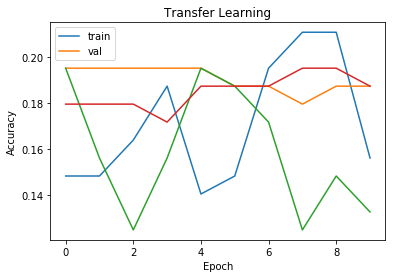

In [152]:
# Fit the model on the batches generated by datagen.flow().
history = History()
callbacks = [history]

history = head_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                          epochs=DEFAULT_NB_EPOCH,
                                          steps_per_epoch=X_train.shape[0] // batch_size,
                                          validation_data=(X_val, Y_val),
                                          validation_steps = X_val.shape[0] // batch_size,
                                          verbose = 2)

print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Parameters Used: \n'+caption)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('acc_stan_' + str(ITERATION) + '.png')
plt.close()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Parameters Used: \n'+caption)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('loss_stan_' + str(ITERATION) + '.png')
plt.close()


'channels_last'

X_train shape: (128, 3, 48, 48)
Y_train shape: (128, 7)
X_val shape: (128, 3, 48, 48)
Y_val shape: (128, 7)
128 train samples
128 val samples


X_train shape: (128, 48, 48, 3)
